# 번역가는 대화에도 능하다 [프로젝트]

- 루브릭
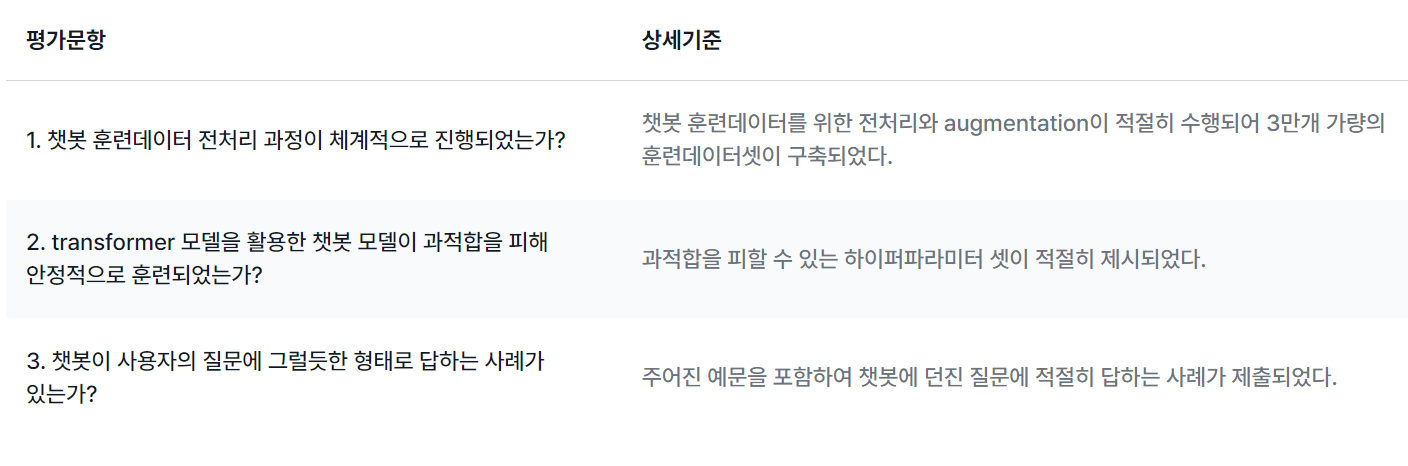

## 데이터 전처리
- 한국어 데이터를 형태소로 나누고 중복을 제거했다
- 데이터를 유의단어로 넣고 바꿔줬다
- 7000개의 병렬데이터셋을 복사해서 3배로 늘려줬다

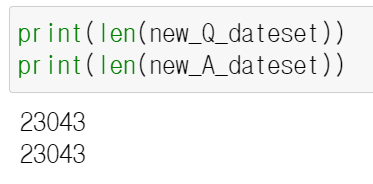

## epoch 10 결과 (loss = 0.5)

# 파라미터 변경을해보자
- n_layer를 1로 줄이고 d_model 512->368, d_ff 2048 -> 1024, dropout 0.3 ->0.2 warmup step 3000 -> 1000 으로 줄였다
- 데이터셋에 비해서 더 큰 모델이었던걸까 모델의 크기를 줄이니 loss가 낮아졌다

## epoch 10 (loss = 0.2)
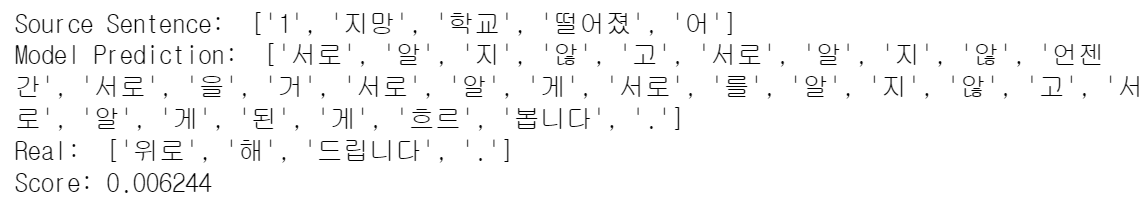
- loss만 봤을때는 꽤 괜찮아 보였지만 
- 실제 결과는 오히려 개판이었다..

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import numpy 
import pandas 
import tensorflow 
import nltk
import gensim

# 데이터 만들기

In [2]:
df = pd.read_csv('ChatbotData.csv')
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
questions = df['Q']
answers   = df['A']

In [4]:
questions.head()

0             12시 땡!
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
Name: Q, dtype: object

In [5]:
def preprocess_sentence(sentence): 
    sentence = sentence.lower().strip()
    sentence = re.sub(r"[^0-9가-힣a-zA-Z?.!,]+", " ", sentence)
    return sentence

In [6]:
from konlpy.tag import Mecab
# KoNLPy의 mecab 객체 생성
mecab = Mecab()

In [7]:
def build_corpus(source_sentences, target_sentences, tokenize_fn, max_length=50):
    # 소스와 타겟 데이터를 정제하고 토큰화한 결과를 저장할 리스트
    source_corpus = []
    target_corpus = []

    # 중복 방지용 세트
    unique_sources = set()
    unique_targets = set()

    for source, target in zip(source_sentences, target_sentences):
        # 문장 전처리
        source_cleaned = preprocess_sentence(source)
        target_cleaned = preprocess_sentence(target)

        # 토큰화
        source_tokens = tokenize_fn(source_cleaned)
        target_tokens = tokenize_fn(target_cleaned)

        # 길이 제한 확인
        if len(source_tokens) <= max_length and len(target_tokens) <= max_length:
            # 중복 체크 후 저장
            source_tuple = tuple(source_tokens)
            target_tuple = tuple(target_tokens)
            
            if source_tuple not in unique_sources and target_tuple not in unique_targets:
                source_corpus.append(source_tokens)
                target_corpus.append(target_tokens)
                
                unique_sources.add(source_tuple)
                unique_targets.add(target_tuple)

    return source_corpus, target_corpus

# 질문과 답변 데이터를 각각 que_corpus와 ans_corpus에 저장
que_corpus, ans_corpus = build_corpus(questions, answers, mecab.morphs)

# 결과 확인
print("Questions Corpus:", que_corpus[105:110])
print("Answers Corpus:", ans_corpus[105:110])


Questions Corpus: [['결혼식', '때', '하객', '이', '없', '을', '까', '봐', '걱정', '돼'], ['결혼식', '이', '너무', '많', '아'], ['결혼', '이나', '하', '지', '왜', '자꾸', '나', '한테', '화', '내', '냐구', '!'], ['결혼', '준비', '하', '는', '데', '돈', '얼마나', '드', '나'], ['결혼', '하', '는', '데', '돈', '많이', '드', '네']]
Answers Corpus: [['생각', '보다', '신경', '안', '씁니다', '.'], ['인맥', '이', '넓', '으신가', '봐요', '.'], ['힘들', '겠', '네요', '.'], ['욕심', '에', '따라', '천지', '차이', '일', '거', '예요', '.'], ['허례허식', '이', '에요', '.']]


## 데이터 augmatation - [gensim]
- Word2Vec embedding을 이용해서 유의어로 변경해서 데이터를 늘렸다 3배

In [8]:
from gensim.models import Word2Vec

In [9]:
import gensim
# 버전이 3.8.3이어야 오류가 나지않는다
print(gensim.__version__)

3.8.3


In [10]:
model = Word2Vec.load("ko.bin")

In [11]:
# 안녕과 비슷한 단어가 절망이라니..
model.most_similar("안녕")

/tmp/ipykernel_548/2074444346.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar("안녕")


[('절망', 0.5654082298278809),
 ('이여', 0.5418729782104492),
 ('청춘', 0.49956801533699036),
 ('첫사랑', 0.49405190348625183),
 ('이별', 0.4899892210960388),
 ('슬픔', 0.48582565784454346),
 ('추억', 0.4816262125968933),
 ('사랑', 0.4783991873264313),
 ('내일', 0.4614541232585907),
 ('!', 0.4595344662666321)]

In [12]:
def lexical_sub(sentence, model):
    # 문장에서 무작위로 단어 선택
    selected_tok = random.choice(sentence)
    
    # 유사한 단어로 변환된 결과 문장을 저장할 변수
    result = []
    
    for tok in sentence:
        if tok == selected_tok:
            try:
                # 선택된 단어와 유사한 단어로 대체
                similar_word = model.most_similar(tok)[0][0]
                result.append(similar_word)
            except KeyError:
                # 단어가 임베딩 모델에 없을 경우 원래 단어 사용
                result.append(tok)
        else:
            result.append(tok)
    
    return result

In [ ]:
lexical_sub(['안녕', '나는', '박형철', '바나나', '를', '좋아','하지'], model)

In [14]:
Q_new_corpus = []

for old_src in tqdm(que_corpus):
    new_src = lexical_sub(old_src, model)
    if Q_new_corpus is not None: 
        Q_new_corpus.append(new_src)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다
#     Q_new_corpus.append(old_src)

print(Q_new_corpus[:10])

  0%|          | 0/7681 [00:00<?, ?it/s]

/tmp/ipykernel_548/430929113.py:12: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  similar_word = model.most_similar(tok)[0][0]


[['12', '시', '끗', '!'], ['1', '지망', '학교', '떨어졌', '어'], ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'], ['ppl', '심하', '네'], ['sd', '카드', '망가졌', '어'], ['sns', '맞', '팔', '과연', '안', '하', '지'], ['sns', '분간', '낭비', '인', '거', '아', '는데', '매일', '하', '는', '중'], ['sns', '보', 'ㄴ다면', '나', '만', '빼', '고', '다', '행복', '해', '보여'], ['이따금', '궁금', '해'], ['이따금', '은', '혼자', '인', '게', '좋', '다']]


In [15]:
A_new_corpus = []

for old_src in tqdm(ans_corpus):
    new_src = lexical_sub(old_src, model)
    if A_new_corpus is not None: 
        A_new_corpus.append(new_src)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다
#     A_new_corpus.append(old_src)

print(A_new_corpus[:10])

  0%|          | 0/7681 [00:00<?, ?it/s]

/tmp/ipykernel_548/430929113.py:12: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  similar_word = model.most_similar(tok)[0][0]


[['하루', '가', '또', '가', '군요', '.'], ['무릎', '해', '드립니다', '.'], ['여행', '은', '언제나', '좋', '지요', '.'], ['눈살', '이', '찌푸려', '지', '죠', '.'], ['다시', '새로', '사', '는', '도록', '마음', '편해요', '.'], ['잘', '모르', '고', '없', '을', '수', '도', '없', '어요', '.'], ['시간', '을', '정하', '고', '해의', '보', '세요', '.'], ['자랑', '하', '는', '자리', '니까요', '는데'], ['그', '사람', '때문', '그럴', '거', '예요', '.'], ['혼자', '를', '즐기', '세요', '는데']]


In [16]:
# augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.
# 3가지 dataset 구축 
# Q - A
# aQ - A
# Q - aA

new_Q_dateset = que_corpus + Q_new_corpus + que_corpus
new_A_dateset = ans_corpus + ans_corpus + A_new_corpus

In [17]:
print(len(new_Q_dateset))
print(len(new_A_dateset))

23043
23043


In [18]:
def add_end_tok(sentences):
    new_sentences = []
    for sentence in sentences:
        new_sentence = ["<start>"] + sentence + ["<end>"]
        new_sentences.append(new_sentence)
    return new_sentences

In [19]:
sample_data = ["12", "시", "땡", "!"]

print(["<start>"] + sample_data + ["<end>"])

['<start>', '12', '시', '땡', '!', '<end>']


In [20]:
new_A_dataset2 = add_end_tok(new_A_dateset)

In [21]:
new_A_dataset2[:3]

[['<start>', '하루', '가', '또', '가', '네요', '.', '<end>'],
 ['<start>', '위로', '해', '드립니다', '.', '<end>'],
 ['<start>', '여행', '은', '언제나', '좋', '죠', '.', '<end>']]

In [22]:
def ko_tokenize(tokenized_corpus, VOCA_SIZE):
   
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCA_SIZE,filters='')
    tokenizer.fit_on_texts(tokenized_corpus)

    return tokenizer

def vectorize(tokenized_corpus, tokenizer):
    tensor = tokenizer.texts_to_sequences(tokenized_corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=50)
    return tensor

In [23]:
VOCAB_SIZE = 20000

tokenizer = ko_tokenize(new_Q_dateset + new_A_dataset2, VOCAB_SIZE)
enc_train = vectorize(new_Q_dateset, tokenizer)
dec_train = vectorize(new_A_dataset2, tokenizer)

# tokenizer.set_encode_extra_options("bos:eos")  # 문장 양 끝에 <s> , </s> 추가

In [24]:
enc_train.shape

(23043, 50)

In [25]:
dec_train.shape

(23043, 50)

In [26]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).batch(batch_size=BATCH_SIZE)


# 모델 구축

In [27]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [28]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [29]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [30]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [31]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [32]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [33]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [34]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [35]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [36]:
transformer = Transformer(
    n_layers=1 ,  # 2
    d_model=368, # 512
    n_heads=8,
    d_ff=1024, # 1024
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512

In [37]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=1000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [38]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [39]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [40]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [41]:
# Q. 위의 코드를 활용하여 모델을 훈련시켜봅시다!
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for step, batch in enumerate(train_dataset):
        loss, enc_attns, dec_attns, dec_enc_attns = train_step(batch[0],batch[1],transformer,optimizer)
        total_loss += loss
                # tqdm 바 업데이트
        tqdm_bar.update(1)
        tqdm_bar.set_postfix({'loss': f'{total_loss / (step + 1):.4f}'})

    
    tqdm_bar.close()
    print(f"Epoch {epoch+1}/{EPOCHS} finished with loss: {total_loss / dataset_count:.4f}")



Epoch 1/10:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 1/10 finished with loss: 4.8968


Epoch 2/10:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 2/10 finished with loss: 2.8069


Epoch 3/10:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 3/10 finished with loss: 1.8285


Epoch 4/10:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 4/10 finished with loss: 1.1327


Epoch 5/10:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 5/10 finished with loss: 0.6791


Epoch 6/10:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 6/10 finished with loss: 0.4770


Epoch 7/10:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 7/10 finished with loss: 0.3613


Epoch 8/10:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 8/10 finished with loss: 0.3007


Epoch 9/10:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 9/10 finished with loss: 0.2570


Epoch 10/10:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 10/10 finished with loss: 0.2277


# 추론 진행 
- 추론은 따로 train과 test를 나눠두지않았기 때문에 그냥 train 데이터로 진행한다

In [42]:
def sequences_to_texts(sequences, tokenizer):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))  # 인덱스를 단어로 매핑
    return [" ".join([reverse_word_map.get(i, "") for i in seq]) for seq in sequences]


def generate(tokens, model, src_tokenizer, tgt_tokenizer):
    # 문장이 들어온다 str타입 1개가 들어와야한다
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.word_index['<start>']], 0)  
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.word_index['<end>'] == predicted_id:
            result = sequences_to_texts(ids, tgt_tokenizer)
            return result

        ids.append([predicted_id])
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    
    result = sequences_to_texts(ids, tgt_tokenizer)
    return result

In [43]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = src_tokenizer.texts_to_sequences(src_sentence)
    tgt_tokens = tgt_tokenizer.texts_to_sequences(tgt_sentence)

    if (len(src_tokens) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None

    reference = tgt_sentence
    candidate = generate(src_tokens, model, src_tokenizer, tgt_tokenizer)

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score

In [48]:
test_idx = 1505

MAX_LEN = 50
eval_bleu_single(transformer, 
                 que_corpus[test_idx], 
                 ans_corpus[test_idx], 
                 tokenizer, 
                 tokenizer)



Source Sentence:  ['신혼', '여행', '가', '서', '돌아오', '기', '싫', '다']
Model Prediction:  ['약간', '의', '변화', '를', '줘', '보', '세요', '는데']
Real:  ['휴가', '를', '붙여', '보', '세요', '.']
Score: 0.065006



0.06500593260343691

## 회고
- 결과가 그렇게 좋지는 않다. 더 많은 데이터? 더 좋은 모델로 한다면 좋지 않을까?
- 모델의 크기를 낮추니 loss는 낮아졌지만 체감상 결과가 그렇게 좋지는 않다.
- 코드를 따라서 데이터에 맞게 바꾸고 결과를 나오게 만드는것 까지는 해보았다.
- 여기서 하이퍼 파라미터 튜닝을 하는 부분을 생각을 하지 못하겠다
    - 어떤 부분을 비교해야할까 어떤 식으로 비교해야할까 어떤 hyper파라미터를 변경해야 될까
    - 그리고 어떤 방법으로 하이퍼 파라미터를 효율적으로 비교할수있을까 -> w&b, tensorboard
    - 이런 생성 모델 같은경우는 문맥이 맞으면되는거지 BLUE점수는 상관이없는것은 느낌이다. 어떤 평가지표를 설정해야할까